<a href="https://colab.research.google.com/github/koreahong/parking_lot_analysis/blob/main/%EC%A3%BC%EC%B0%A8%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#라이브러리 불러오기

In [ ]:
# !pip install --target=$my_path pycaret
!pip install  category_encoders
!pip install  catboost

In [ ]:
#download pont
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv 
!rm ~/.cache/matplotlib -rf 

In [1]:
import pandas as pd
import numpy as np
import copy
import math

#시각화
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

#통계
from scipy.stats import skew
from scipy  import stats

#데이터전처리
from sklearn.preprocessing import OneHotEncoder

#머신러닝 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

#경고무시
import warnings
warnings.filterwarnings("ignore")

#폰트설정
plt.rc('font', family='NanumBarunGothic') 

In [171]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

In [3]:
#mount google drive 
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [361]:
train = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/train.csv")

In [362]:
test = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/test.csv")

In [506]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

- train 데이터 -> 임대보증금, 임대료, 버스정류장 수 등 null값 존재

In [507]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int64  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float64
 6   전용면적별세대수                      1022 non-null   int64  
 7   공가수                           1022 non-null   float64
 8   자격유형                          1020 non-null   object 
 9   임대보증금                         842 non-null    object 
 10  임대료                           842 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  980 non-null    float64
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float64
 13  단지내

- test 데이터 -> 임대보증금, 임대료, 지하철 수  null값 존재

### 어려운 컬럼 이름 간편하게 변경

In [7]:
train.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철', \
                      '도보 10분거리 내 버스정류장 수':'버스'}, inplace=True)

In [8]:
test.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철', \
                      '도보 10분거리 내 버스정류장 수':'버스'}, inplace=True)

### 임대료, 임대보증금 int로 변환
- 지역별로 평균을 내서 넣었으나 -1으로 넣은것과 예측이 크게 다르지 않음

In [508]:
train['임대료'] = train['임대료'].fillna(-1)
train['임대보증금'] = train['임대보증금'].fillna(-1)

In [509]:
train['임대료'] = train['임대료'].replace('-', -1)
train['임대보증금'] = train['임대보증금'].replace('-', -1)

In [510]:
test['임대료'] = test['임대료'].fillna(-1)
test['임대보증금'] = test['임대보증금'].fillna(-1)

In [511]:
test['임대료'] = test['임대료'].replace('-', -1)
test['임대보증금'] = test['임대보증금'].replace('-', -1)

In [512]:
train['임대료'] = train['임대료'].astype(int)
train['임대보증금'] = train['임대보증금'].astype(int)

In [513]:
test['임대료'] = test['임대료'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

### 자격유형 null값 넣기
- 동일한 단지내에 같은 유형으로 넣기

In [514]:
test[test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [515]:
test.iloc[196, 8] = 'A'

In [516]:
test.iloc[258, 8] = 'C'

In [526]:
def apt_groupby_statistic(df, train=True):
  """
  단지별 통계치와 아파트타입 생성
  """
  def apart_type(x):
    """
    전용면적별 아파트타입 분류 {초소형, 소형, 중형&대형}
    """
    if x <= 40:
      return '초소형'
    elif 40 < x < 60:
      return '소형'
    else:
      return '중형&대형'

  df_apt = df[df.임대건물구분 == '아파트'].copy()
  df_apt['아파트부지'] = df_apt['전용면적'] * df_apt['전용면적별세대수']
  df_apt['아파트타입'] = df_apt['전용면적'].apply(apart_type)
  df_apt['개수'] = 1

  apart_type_temp = df_apt.groupby(['단지코드', '아파트타입'])['개수'].mean().unstack(1).fillna(0).reset_index()

  if train:
    apt_temp = df_apt.groupby('단지코드').agg({'총세대수':'mean', '전용면적':['max'], '아파트부지':'sum', '공가수':'mean', '임대보증금':['max'], '임대료':['max'], '단지내주차면수':'mean', '등록차량수':'mean'}).reset_index()
    apt_temp.columns = ['단지코드', '총세대수', '아파트단지내최대전용면적', '아파트부지', '공가수', '아파트최대임대보증금', '아파트최대임대료', '단지내주차면수', '등록차량수']
  else:
    apt_temp = df_apt.groupby('단지코드').agg({'총세대수':'mean', '전용면적':['max'], '아파트부지':'sum', '공가수':'mean', '임대보증금':['max'], '임대료':['max'], '단지내주차면수':'mean'}).reset_index()
    apt_temp.columns = ['단지코드', '총세대수', '아파트단지내최대전용면적', '아파트부지', '공가수', '아파트최대임대보증금', '아파트최대임대료', '단지내주차면수']


  ### 통계치 + 아파트타입
  temp = pd.merge(apt_temp, apart_type_temp)
  return temp

In [527]:
def store_groupby_statistic(df):
  df_store = df[df.임대건물구분 == '상가'].copy()
  df_store['상가부지'] = df_store['전용면적'] * df_store['전용면적별세대수']


  store_temp = df_store.groupby('단지코드').agg({'전용면적':['max'], '상가부지':'sum', '임대보증금':['max'], '임대료':['max']}).reset_index()
  store_temp.columns = ['단지코드', '상가단지내최대전용면적', '상가부지', '상가최대임대보증금', '상가최대임대료']
  return store_temp

In [528]:
train_apt_store = pd.merge(apt_groupby_statistic(train_copy), store_groupby_statistic(train_copy), how='left', on='단지코드')
test_apt_store = pd.merge(apt_groupby_statistic(test_copy,False), store_groupby_statistic(test_copy), how='left', on='단지코드')

In [529]:
train_apt_store = train_apt_store.fillna(0)
test_apt_store = test_apt_store.fillna(0)

In [530]:
train_apt_store['아파트주거비율'] = train_apt_store['아파트부지'] / (train_apt_store['아파트부지'] + train_apt_store['상가부지'])
test_apt_store['아파트주거비율'] = test_apt_store['아파트부지'] / (test_apt_store['아파트부지'] + test_apt_store['상가부지'])

### 가정3 공급유형별로 등록수 차이가 있는지
- 공급유형은 크게 영향을 끼치지 않음.

### 지역컬럼 넣기

In [553]:
train_apt_store['지역'] = train_copy.sort_values('단지코드').drop_duplicates('단지코드', keep='first').지역.reset_index(drop=True)

In [556]:
test_apt_store['지역'] = test_copy.sort_values('단지코드').drop_duplicates('단지코드', keep='first').지역.reset_index(drop=True)

In [555]:
set(test_final.columns) - set(train_final.columns)
set(train_final.columns) - set(test_final.columns)

{'등록차량수'}

### 데이터분할 및 인코딩

In [557]:
X = train_apt_store.drop(['단지코드', '등록차량수'], axis=1)
y = train_apt_store['등록차량수']

In [558]:
test_co = test_apt_store.drop(['단지코드'], axis=1)

In [559]:
categorical_feats = X.dtypes[X.dtypes == 'object'].index

In [560]:
features_index = X.dtypes[X.dtypes != 'object'].index

In [561]:
encoder = OrdinalEncoder(categorical_feats)
X[categorical_feats] = encoder.fit_transform(X[categorical_feats], y)
test_co[categorical_feats] = encoder.transform(test_co[categorical_feats])

### 모델링

In [562]:
n_est = 4000
seed = 42
n_fold = 20
n_class = 1

target = '등록차량수'
X_test = test_co.copy()

In [ ]:
skfold = KFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros(X.shape[0])
cat_pred_test = np.zeros(X_test.shape[0])
cat_cols = categorical_feats.tolist()

for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostRegressor()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict(X_valid)
  cat_pred_test += model_cat.predict(X_test) / n_fold
  print(f'CV MAE Score: {mean_absolute_error(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\t MAE: {mean_absolute_error(y, cat_pred):.6f}')

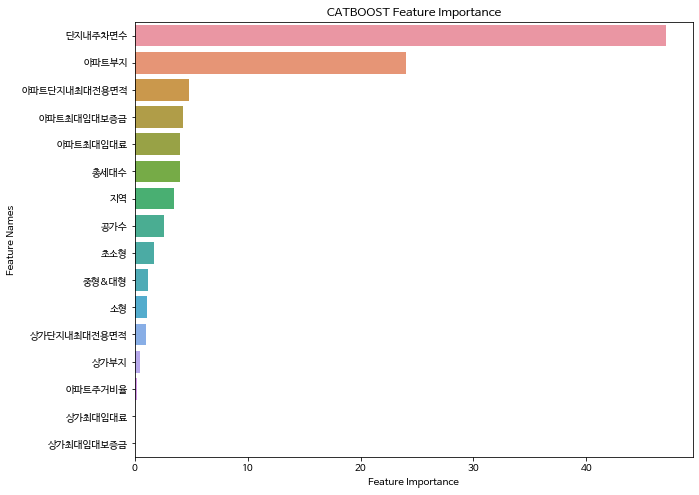

In [564]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    fig = plt.figure(figsize=(10,8))
    fig.set_facecolor("white")
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [493]:
data = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/result/result17.csv")

In [494]:
sub = pd.read_csv("/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/data/sample_submission.csv")

In [495]:
result = pd.DataFrame(cat_pred_test)

In [496]:
result['단지코드'] = test_final['단지코드']

In [497]:
result = result.groupby('단지코드').mean().reset_index()
result.columns = ['code', 'num']

In [498]:
sorter = sub['code']

In [499]:
sorterIndex = dict(zip(sorter, range(len(sorter))))

In [500]:
result['Rank'] = result['code'].map(sorterIndex)

In [501]:
result.sort_values('Rank', inplace=True)

In [502]:
sub = result.iloc[:, :-1].reset_index(drop=True)

In [503]:
sub

,code,num
0,C1072,763.058499
1,C1128,1312.739899
2,C1456,613.406169
3,C1840,520.452340
4,C1332,1260.232359
...,...,...
145,C2456,255.863843
146,C1266,483.417171
147,C2152,102.586238
148,C1267,429.471366


In [504]:
import os
path = "/content/drive/My Drive/머신러닝_실전예제/Dacon_주차수요예측/result/"
file_list = os.listdir(path)
file_list_csv = [file for file in file_list if file.endswith(".csv")]
num = len(file_list_csv) + 1

In [505]:
sub.to_csv(path + "result" + str(num) + ".csv", index=False)